# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
from mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, plot_property, _extract_interface, find_nearest

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [2]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

# mb_comparison = True
mb_comparison = False

if(mb_comparison):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb5",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb3",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb1",
                ]
else:
    scenarios = [
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc",
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf",
                ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
             'temperature_anomaly',
             'surface',
             'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_dataset):
        properties.append('pressure')
    if ('temperature' not in new_dataset):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max

In [3]:
properties, new_datasets

(['lithology', 'strain_rate', 'temperature_anomaly', 'surface', 'viscosity'],
 ['strain', 'density', 'strain_rate', 'temperature', 'surface', 'viscosity'])

[0, 4000.0] [-660.0, 40]


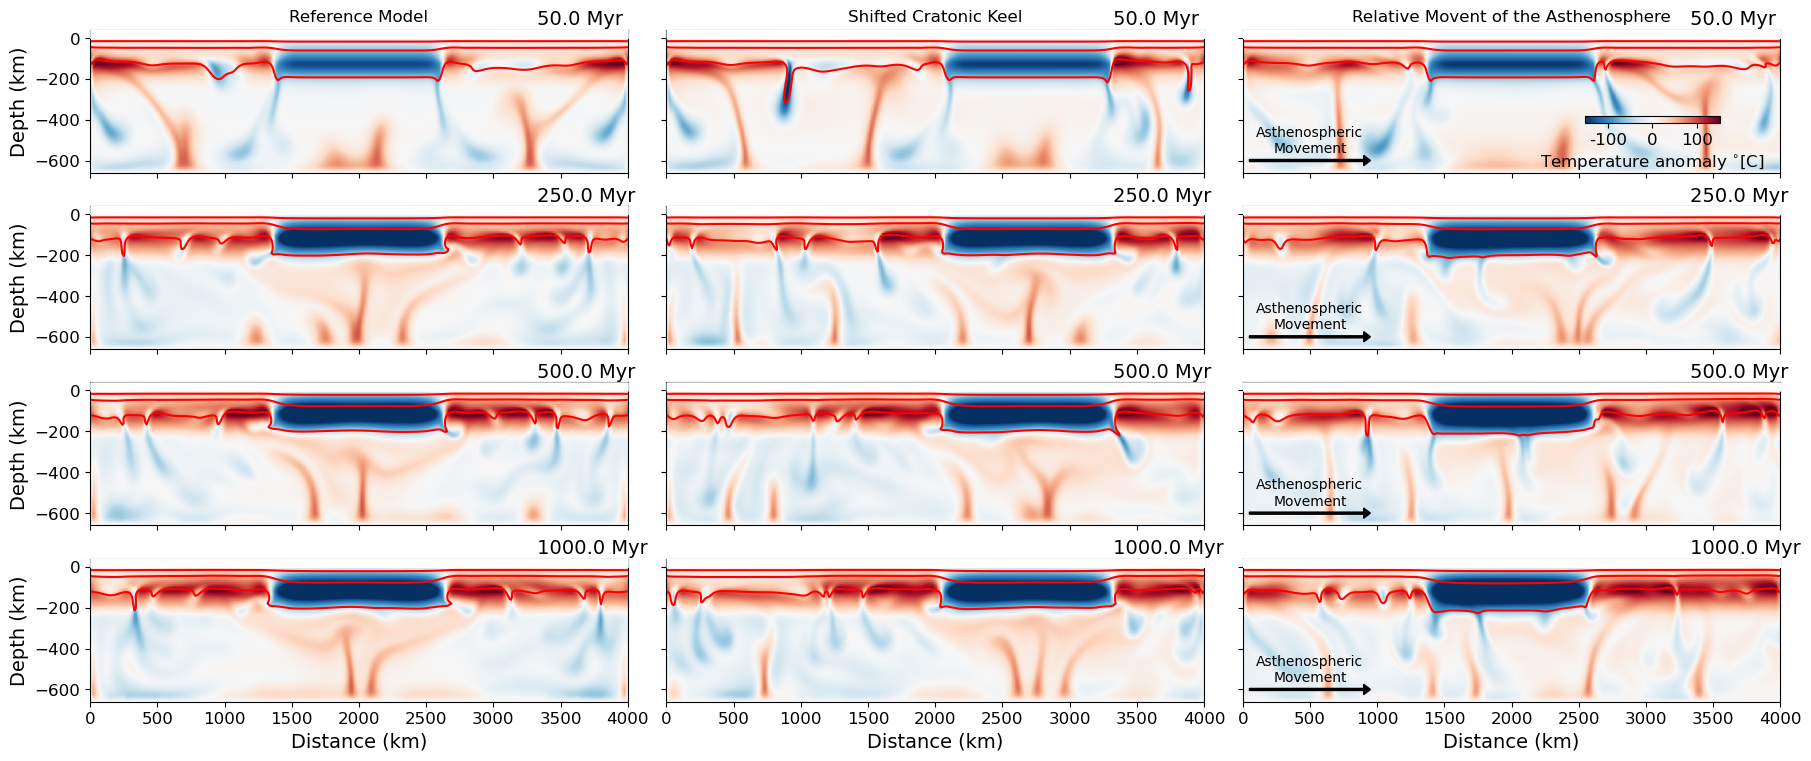

In [25]:

##############################################################################################################
#Creating path to the experiment

# fpath = machine_path + scenario
# print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
# prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

##############################################################################################################
#Set instants
if(prop != 'surface'):
    instants = [50, 250, 500, 1000] #Myr
else:
    instants = [0, 250, 500, 1000]

##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 3, constrained_layout=True, figsize=(18, fig_height), sharex=False, sharey=True)
else:
    fig, axs = plt.subplots(len(instants), 3, constrained_layout=True, figsize=(18,4), sharex=False, sharey=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

i = 0
# zoom_uc = True
zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50]
        ylims = [-40, 10]
        # plot steps
        plot_particles = True
    else:
        xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 150, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 150]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.5, 1.5]

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    plot_property(dataset0.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[3*i],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )

    if(mb_comparison):
        xlims_aux = xlims
        ylims_aux = ylims
    else:
        if(zoom_uc):
            shift_craton = 700.0 #km
            xlims_aux = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50 + shift_craton, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50 + shift_craton]
            ylims_aux = [-40, 10]
        else:
            shift_craton = 700.0 #km
            xlims_aux = xlims
            ylims_aux = ylims

    plot_property(dataset1.isel(time=idx), prop, xlims_aux, ylims_aux, scenarios[1],
            fig,
            axs[3*i+1],
            plot_isotherms = plot_isotherms,
            plot_particles = plot_particles,
            particle_size = 0.2,
            particle_marker = ".",
            ncores = 20,
            #  step_plot = 4,
            isotherms = [500, 800, 1300],
            plot_colorbar=False,
            # plot_melt = plot_melt,
            # melt_method = melt_method,
            )

    plot_property(dataset2.isel(time=idx), prop, xlims, ylims, scenarios[2],
                fig,
                axs[3*i+2],
                plot_isotherms = plot_isotherms,
                plot_particles = plot_particles,
                particle_size = 0.2,
                particle_marker = ".",
                ncores = 20,
                # step_plot = 4,
                isotherms = [500, 800, 1300],
                plot_colorbar=plot_colorbar,
                # plot_melt = plot_melt,
                # melt_method = melt_method,
                )
    
# axs[0].set_title(r'CKR')
# axs[1].set_title(r'CKS')
        
# axs[1].set_title(r'CKMD0.01')
if(mb_comparison): 
    axs[0].set_title(r'Mobile Belt: 5 $\times$ Wet Olivine')
    axs[1].set_title(r'Mobile Belt: 3 $\times$ Wet Olivine')
    axs[2].set_title(r'Mobile Belt: 1 $\times$ Wet Olivine')
else:
    axs[0].set_title(r'Reference Model')
    axs[1].set_title(r'Shifted Cratonic Keel')
    axs[2].set_title(r'Relative Movent of the Asthenosphere')


label_fsize = 14
for i in range(len(instants)):
    # axs[2*i].set_title(f"{letters[i]} - {instants[i]} Myr")
    # axs[2*i+1].set_title(f"{letters[i]} - {instants[i]} Myr")
    axs[3*i].set_ylabel('Depth (km)', fontsize=label_fsize)

    if(mb_comparison==False):
        axs[3*i+2].text(500, -560, f"Asthenospheric\nMovement", ha='center')
        axs[3*i+2].arrow(50, -600, 850, 0, width=10, head_width=50, head_length=50, fc='k', ec='k')

    if(i == len(instants) - 1):
        axs[3*i].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[3*i+1].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[3*i+2].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[3*i].set_xticklabels([])
        axs[3*i+1].set_xticklabels([])
        axs[3*i+2].set_xticklabels([])

if(zoom_uc):
    if(mb_comparison):
        figname = f"CK_mbwo_comparison_{prop}_zoom_uc"
    else:
        figname = f"CK_ref_vs_shift_vs_aw_{prop}_zoom_uc"
else:
    if(mb_comparison):
        figname = f"CK_mbwo_comparison_{prop}"
    else:
        figname = f"CK_ref_vs_shift_vs_aw_{prop}"

# figname = f"POSTER_CK_ref_vs_shift_vs_aw_{prop}"
# figname = f"CK_mbwo_comparison_{prop}"


fig.savefig(f"figures/{figname}.png", dpi=200)
fig.savefig(f"figures/{figname}.pdf", dpi=200)

In [2]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

scenarios = [
            f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
            f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc",
            # f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf",
    
            # f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow_mbwo_Cmb1",
            # f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow_mbwo_Cmb5",

             ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
            #  'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
             'temperature_anomaly',
             'surface',
             'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_dataset):
        properties.append('pressure')
    if ('temperature' not in new_dataset):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

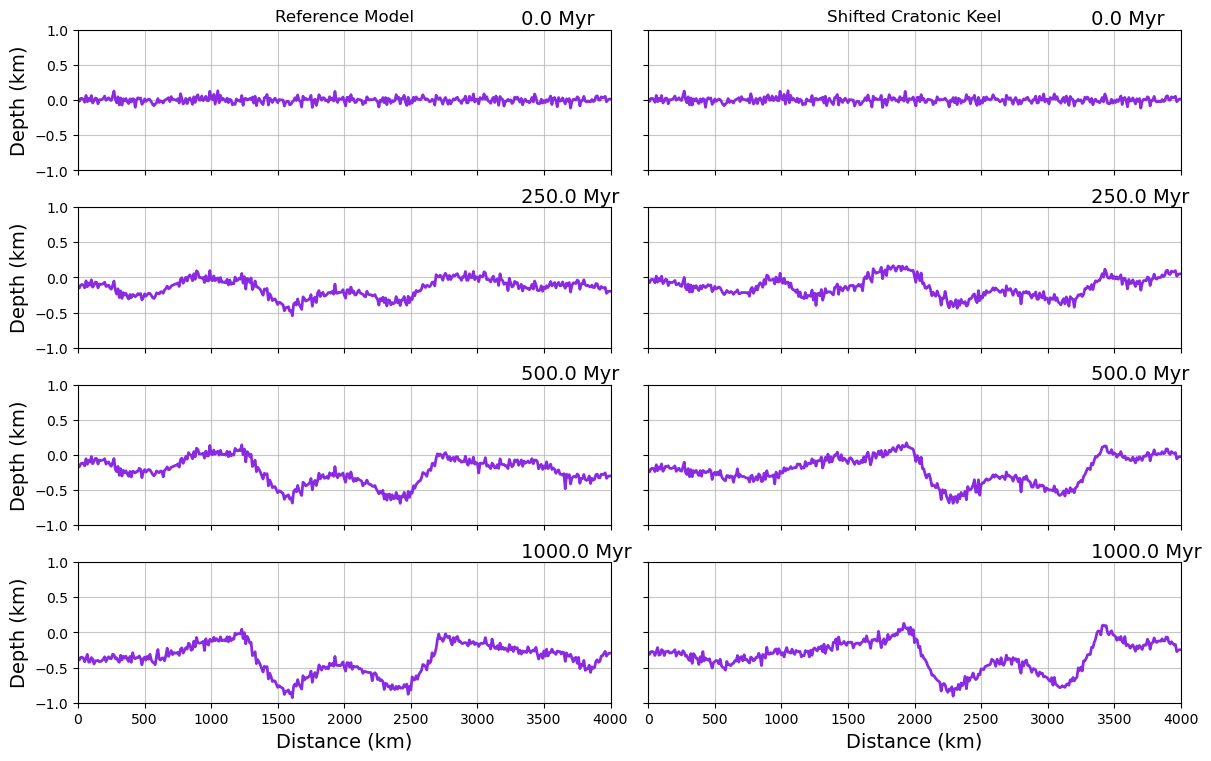

In [3]:

##############################################################################################################
#Creating path to the experiment

# fpath = machine_path + scenario
# print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
# prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'topography'
# prop = 'viscosity'
prop = 'surface'

##############################################################################################################
#Set instants
if(prop != 'surface'):
    instants = [50, 250, 500, 1000] #Myr
else:
    instants = [0, 250, 500, 1000]


##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}
if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 2, constrained_layout=True, figsize=(12, fig_height), sharex=True, sharey=True)
else:
    fig, axs = plt.subplots(len(instants), 2, constrained_layout=True, figsize=(12,4), sharex=True, sharey=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

i = 0
if(prop != 'surface'): # you can customize
    xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
    ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
else:
    xmin = 0 #+ 200
    xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
    xlims = [xmin, xmax]
    ylims = [-1., 1.]

# plot steps
plot_particles = False

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    plot_property(dataset0.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[2*i],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.02,
             particle_marker = "o",
             ncores = 20,
             step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_property(dataset1.isel(time=idx), prop, xlims, ylims, scenarios[1],
             fig,
             axs[2*i+1],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.02,
             particle_marker = "o",
             ncores = 20,
             step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    
# axs[0].set_title(r'CKR')
# axs[1].set_title(r'CKS')
    
axs[0].set_title(r'Reference Model')
axs[1].set_title(r'Shifted Cratonic Keel')
# axs[1].set_title(r'Relative Movent of the Asthenosphere')
        
# axs[1].set_title(r'CKMD0.01')
    
# axs[0].set_title(r'1 $\times$ Wet Olivine Rheology')
# axs[1].set_title(r'5 $\times$ Wet Olivine Rheology')

label_fsize = 14
for i in range(len(instants)):
    # axs[2*i].set_title(f"{letters[i]} - {instants[i]} Myr")
    # axs[2*i+1].set_title(f"{letters[i]} - {instants[i]} Myr")
    axs[2*i].set_ylabel('Depth (km)', fontsize=label_fsize)
    
    if(i == len(instants) - 1):
        axs[2*i].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[2*i+1].set_xlabel('Distance (km)', fontsize=label_fsize)

figname = f"CK_ref_vs_shift_{prop}"
# figname = f"CK_ref_vs_Cmbdo001_{prop}"
# figname = f"CKMBW_Cmb1_vs_Cmb5_{prop}"
# figname = f"CK_ref_vs_aw_{prop}"

fig.savefig(f"figures/{figname}.png", dpi=400)
fig.savefig(f"figures/{figname}.pdf", dpi=400)

# Poster Version

In [3]:
new_datasets, properties

(['strain', 'density', 'temperature', 'surface', 'viscosity'],
 ['lithology', 'temperature_anomaly', 'surface', 'viscosity'])

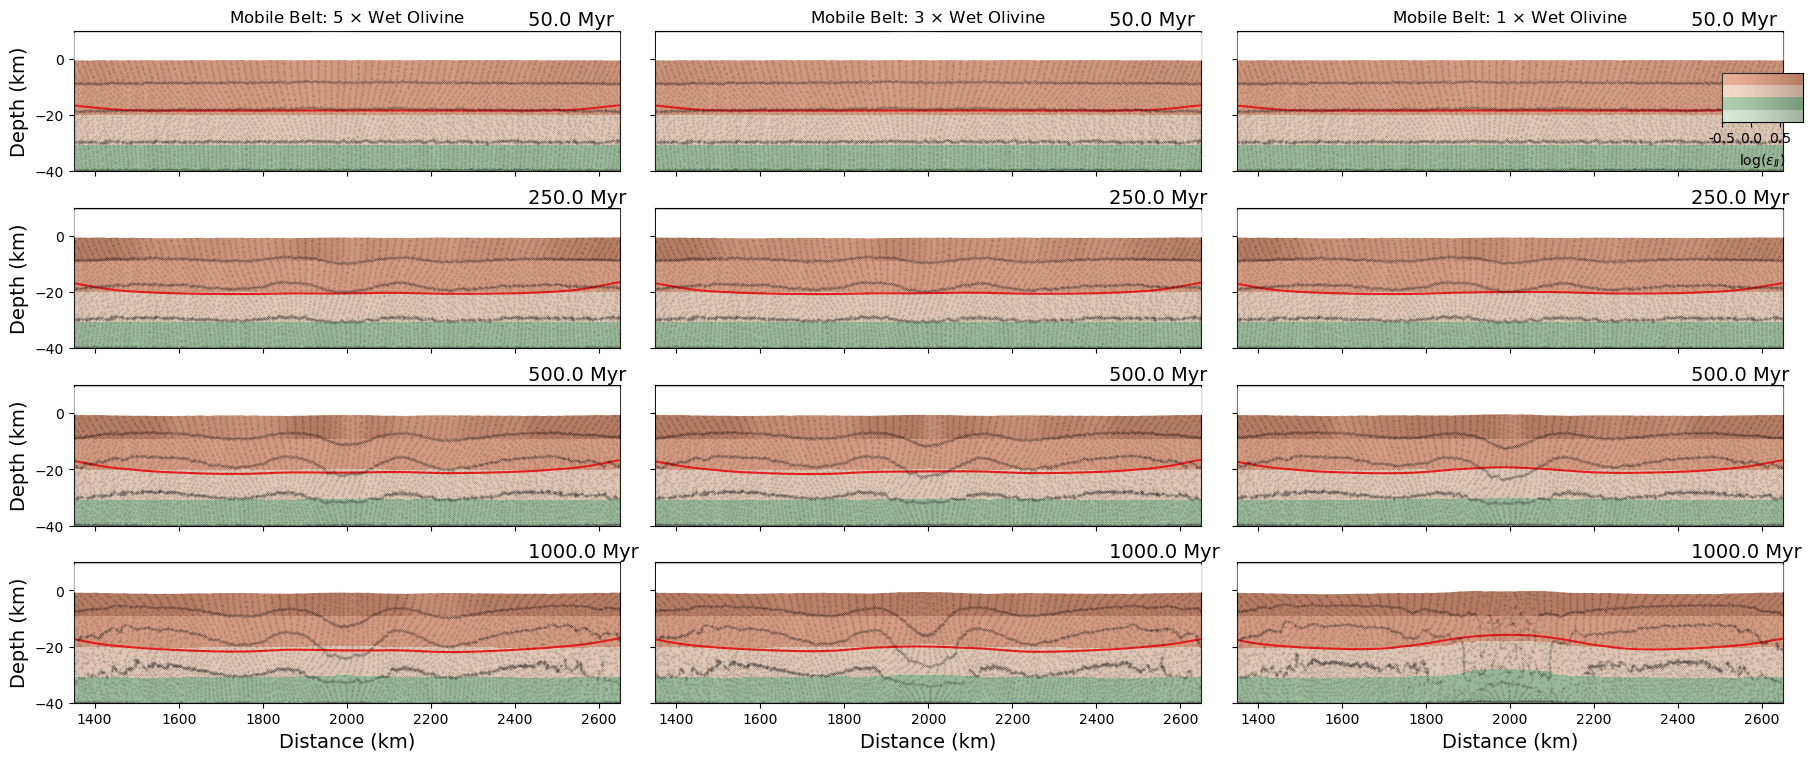

In [ ]:
##############################################################################################################
#Plot data

# if(len(instants) > 1):
#     for instant, ax in zip(instants, axs):
#         idx = find_nearest(times, instant)
#         step = steps[idx]
#         plot_data(fpath, ax, axs, prop, instants, step, xlims, ylims)
#         #print(steps[idx], times[idx], instant)
# else:
#     idx = find_nearest(times, instants[0])
#     step = steps[idx]
#     ax = axs
#     plot_single_step(fpath, axs, prop, instants, step, xlims, ylims)
    
##############################################################################################################
#Setting plot details

# if(len(instants) > 1):
#     axs[0].set_xlim(xlims)
#     axs[0].set_ylim(ylims)

#     fsize = 20
#     axs[-1].set_xlabel('x [km]', fontsize=fsize)
#     for ax, letter, instant in zip(axs, letters, instants):
#         label_text = letter + ') ' + str(instant) + ' Myr'
#         ax.text(0.015,
#                 0.90,
#                 label_text,
#                 color='k',
#                 bbox=dict(edgecolor = 'white',
#                           facecolor = 'white',
#                           alpha = 0.6),
#                 fontsize=fsize,
#                 horizontalalignment='left',
#                 verticalalignment='center',
#                 transform=ax.transAxes,
#                 zorder=52)

#         if(prop != 'topography'):
#             ax.set_ylabel('Depth [km]', fontsize=fsize)
#             ax.tick_params(axis='both', labelsize=fsize)
#             axs[-1].tick_params(axis='both', labelsize=fsize)
# #             ax.set_yticks(np.linspace(ylims[0], 0, 5))
#             ax.set_yticks(np.arange(0, ylims[0], -100))
# #             ax.set_yticks(np.linspace(ylims[0]+60, 0, 7))
#         else:
#             ax.set_ylabel('Topography [km]', fontsize=fsize)
#             ax.tick_params(axis='both', labelsize=fsize)
#             axs[-1].tick_params(axis='both', labelsize=fsize)
#             nticks = np.abs(ylims[1] - ylims[0] + 1)
#             ax.set_yticks(np.linspace(ylims[0], ylims[1], nticks))
#             ax.grid('-k', alpha = 0.7)
# else:
#     axs.set_xlim(xlims)
#     axs.set_ylim(ylims)

#     fsize = 20
#     axs.set_xlabel('x [km]', fontsize=fsize)
    
#     label_text = str(instants[0]) + ' Myr'
#     axs.text(0.015,
#             0.92,
#             label_text,
#             color='k',
#             bbox=dict(edgecolor = 'white',
#                       facecolor = 'white',
#                       alpha = 0.6),
#             fontsize=fsize,
#             horizontalalignment='left',
#             verticalalignment='center',
#             transform=axs.transAxes,
#             zorder=52)

#     if(prop != 'topography'):
#         axs.set_ylabel('Depth [km]', fontsize=fsize)
#         axs.tick_params(axis='both', labelsize=fsize)
#         axs.tick_params(axis='both', labelsize=fsize)
# #         ax.set_yticks(np.linspace(ylims[0], 0, 5))
#         axs.set_yticks(np.linspace(ylims[0]+60, 0, 7))
#     else:
#         axs.set_ylabel('Topography [km]', fontsize=fsize)
#         axs.tick_params(axis='both', labelsize=fsize)
#         axs[-1].tick_params(axis='both', labelsize=fsize)
#         nticks = np.abs(ylims[1] - ylims[0] + 1)
#         axs.set_yticks(np.linspace(ylims[0], ylims[1], nticks))
#         axs.grid('-k', alpha = 0.7)
    
##############################################################################################################
#Saving figure

# if(len(instants) > 1):
#     figname = scenario.split('/')[-2] + '_' + prop
# else:
#     figname = scenario.split('/')[-2] + '_' + prop + '_single_step'
    
# print(figname)

# #This will save inside the notebook directory
# fig.savefig('out/plots/' + figname+'.pdf', dpi=400)
# fig.savefig('out/plots/' + figname+'.png', dpi=400)

# #This will save inside the experiment directory
# fig.savefig(fpath+figname+'.pdf', dpi=400)
# fig.savefig(fpath+figname+'.png', dpi=400)